In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.drop_duplicates(inplace=True, keep = 'first')

### Turn string type to int/float

In [4]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['Month'] = df['Month'].map(month_mapping)

### Encoding the visitor_type

In [5]:
df_encoded = pd.get_dummies(df, columns=['VisitorType', 'Browser', 'Region', 'OperatingSystems','TrafficType'])
df_encoded

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,0,0,0,0,0,0,0,0,0,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,1,0,0,0,0,0,0,0,0,0


## Dealing with Imbalanced Data 

base method:

In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_encoded, test_size = 0.1, random_state=42)
X_test = df_test.drop('Revenue', axis = 1)
y_test = df_test['Revenue'].copy()
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state=42)
X_train = df_train.drop('Revenue', axis = 1)
y_train = df_train['Revenue'].copy()
X_val = df_test.drop('Revenue', axis = 1)
y_val = df_test['Revenue'].copy()

              precision    recall  f1-score   support

       False       0.93      0.96      0.94      1042
        True       0.70      0.58      0.64       179

    accuracy                           0.90      1221
   macro avg       0.82      0.77      0.79      1221
weighted avg       0.90      0.90      0.90      1221



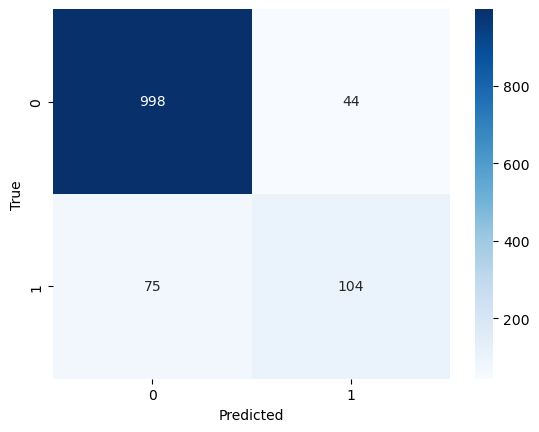

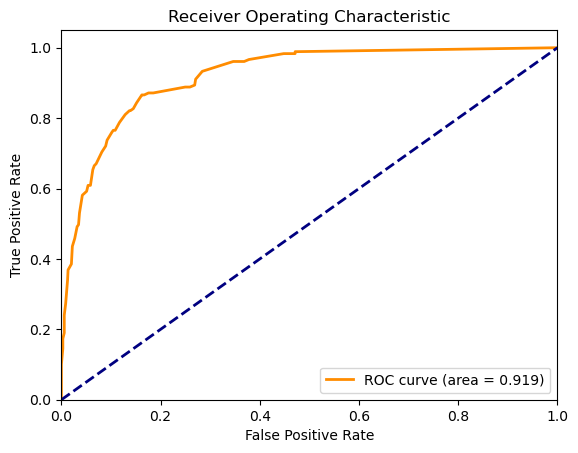

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

pipe = Pipeline([('scaler', StandardScaler()), 
                ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=50, random_state=42))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

y_probs = pipe.predict_proba(X_val)[:, 1]  # the probability of the positive class

# Evaluation
conf_matrix = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))

# confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

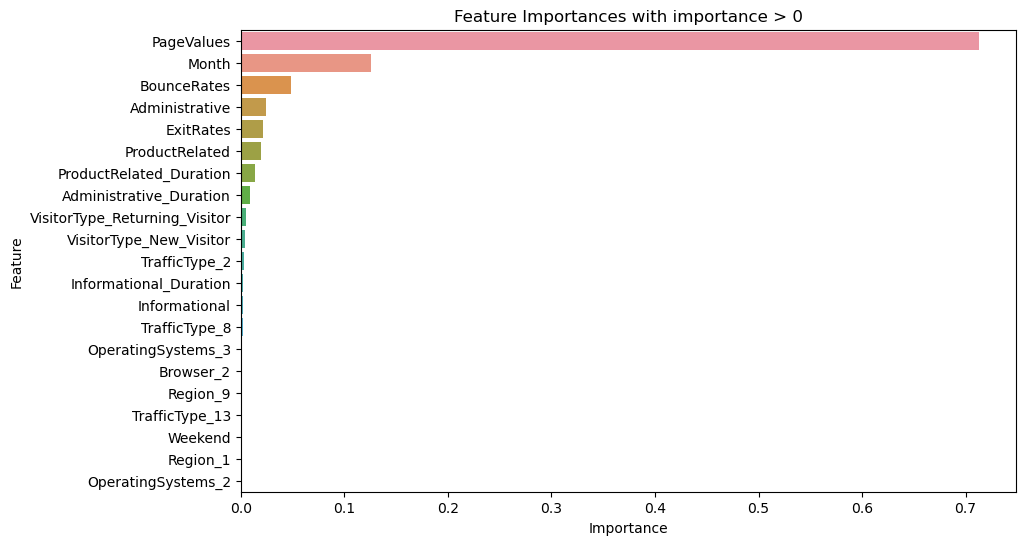

In [8]:
feature_importances = pipe.named_steps['classifier'].feature_importances_


features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})


features_df = features_df[features_df.Importance > 0] # remove feature with zero importance
features_df = features_df.sort_values(by='Importance', ascending=False) # sort by importance

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df)
plt.title('Feature Importances with importance > 0')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Stratified Shuffle Split:

In [9]:
df_feature = df_encoded.drop('Revenue', axis = 1)
df_target = df_encoded['Revenue'].copy()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
for train_index, val_index in sss.split(X_train, y_train):
    X_train = X_train.iloc[train_index]
    y_train = y_train.iloc[train_index]

              precision    recall  f1-score   support

       False       0.93      0.96      0.94      1042
        True       0.70      0.55      0.62       179

    accuracy                           0.90      1221
   macro avg       0.81      0.76      0.78      1221
weighted avg       0.89      0.90      0.90      1221



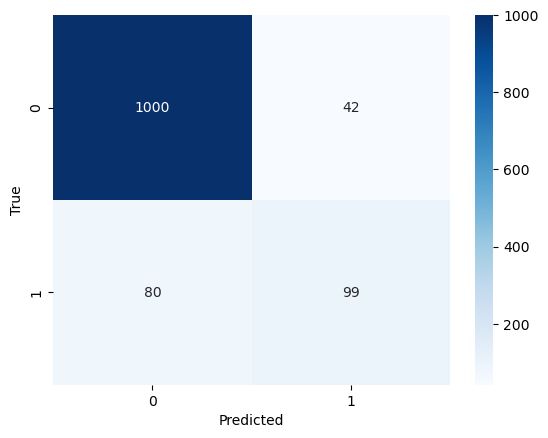

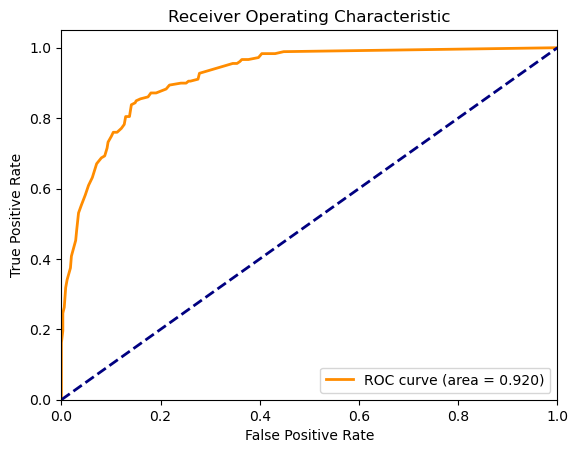

In [11]:
pipe = Pipeline([('scaler', StandardScaler()), 
                ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=50, random_state=42))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

y_probs = pipe.predict_proba(X_val)[:, 1]  # the probability of the positive class

# Evaluation
conf_matrix = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))

# confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Class weight:

              precision    recall  f1-score   support

       False       0.98      0.84      0.90      1042
        True       0.48      0.88      0.62       179

    accuracy                           0.84      1221
   macro avg       0.73      0.86      0.76      1221
weighted avg       0.90      0.84      0.86      1221



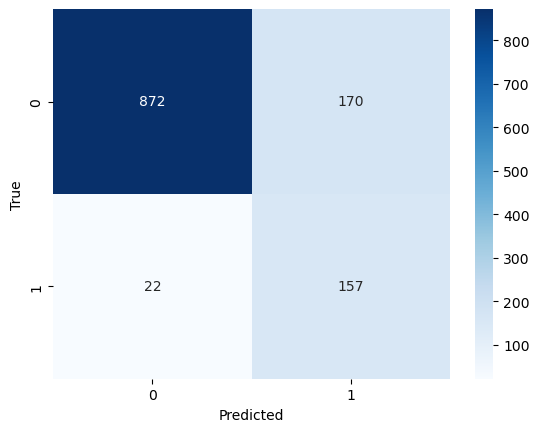

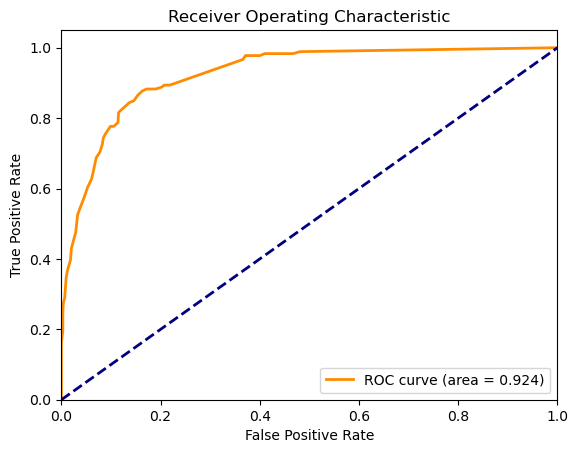

In [12]:
pipe = Pipeline([('scaler', StandardScaler()), 
                ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=10, class_weight='balanced', 
                                                      min_samples_leaf=50, random_state=42))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

y_probs = pipe.predict_proba(X_val)[:, 1]  # the probability of the positive class

# Evaluation
conf_matrix = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))

# confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

SMOTE:

              precision    recall  f1-score   support

       False       0.95      0.91      0.93      1042
        True       0.59      0.74      0.66       179

    accuracy                           0.89      1221
   macro avg       0.77      0.83      0.80      1221
weighted avg       0.90      0.89      0.89      1221



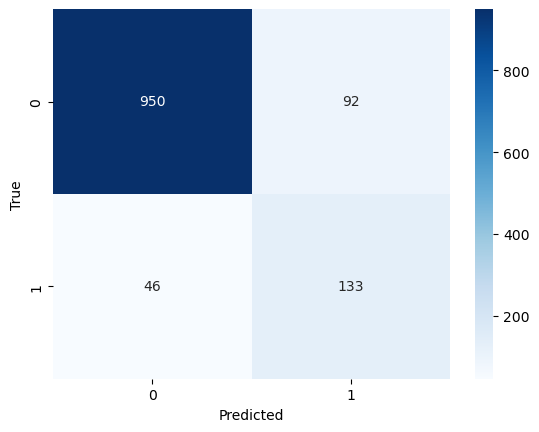

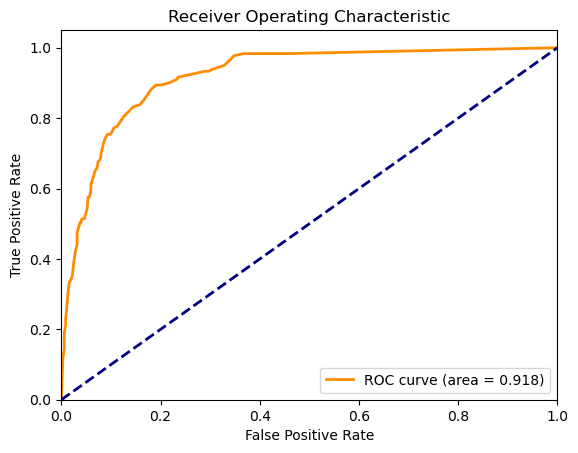

In [13]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', DecisionTreeClassifier(criterion='entropy', max_depth=10, 
                                                       min_samples_leaf=50, random_state=42))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)

y_probs = pipe.predict_proba(X_val)[:, 1]  # the probability of the positive class

# Evaluation
conf_matrix = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))

# confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()